# Accumulator Models

Accumulator models are based on the idea that the decisions process unfolds over a period of time. In that period, evidence in favor of one or more options is accumulated. A decision is made as soon as the evidence for one option exceeds a predefined amount. There are two main families of accumulator models: diffusion models and race models. 

In [23]:
import numpy as np
import random as rnd
import matplotlib.pyplot as plt
import scipy.stats as stat
import scipy
import seaborn as sns
import pandas as pd
import math
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
sns.set_style("whitegrid")


Consider, for example, what has been perhaps the most experimental paradigm to which this model has been applied, the motion coherence detection. In this type of paradigm, participants are presented with an array of moving dots. All of dots are moving and at the same speed, but the degree to which they are moving _in the same direction_ changes across conditions. The Figure illustrates three hypothetical cases in which 0\%, 50\%, or 100\% of the dots are moving to the right. The direction of the coherent motion is not given to participants beforehand; on some trials, the coherent motion might be towards the left and, in other trials, towards the right. Participants are typically instructed to indicate the direction of coherent motion with the left or the right hand. In cases in which this paradigm was carried out in non-human primates, the animals typically respond by performing a saccade, i.e., by moving the eyes in the intended location.


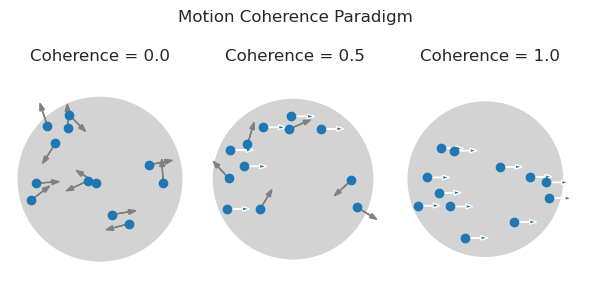

In [2]:
fig, axs = plt.subplots(1, 3, figsize = (6, 3))

points = [[x/10.0, y/10.0] for x in range(10) for y in range(10)]
points = [x for x in points if np.sqrt((x[0]-0.5)**2 + (x[1] - 0.5)**2) < 0.45]

npoints = 12
for i, coh in enumerate((0, 0.5, 1)):
    ax = axs[i]
    circle = plt.Circle((0.5,0.5), 0.5, color='lightgrey')
    ax.add_patch(circle)
    ax.axis('off')
    ax.axis('equal')
    
    # generate dots
    sub = rnd.sample(points, k = npoints)
    
    # jitter
    for p in sub:
        p[0] += rnd.uniform(-0.03, 0.03)
        p[1] += rnd.uniform(-0.03, 0.03)
        
    ax.plot([x[0] for x in sub], [x[1] for x in sub], 'o')
    n = int(npoints * coh)
    move = sub[0:n]
    non_move = sub[n:]
    
    for p in move:
        ax.arrow(p[0], p[1], 0.1, 0, head_width=0.03)
        
    for p in non_move:
        angle = rnd.uniform(0, 2*math.pi)
        dx = math.cos(angle) * 0.1
        dy = math.sin(angle) * 0.1
        ax.arrow(p[0], p[1], dx, dy, head_width=0.03, color='grey')
        
    ax.set_title("Coherence = %.1f" % (coh,))
    
fig.suptitle("Motion Coherence Paradigm")
fig.tight_layout()
#fig.savefig("figures/motion_coherence.png", dpi=200)
plt.show()

## Ratcliff's Drift Diffusion Model


The first category of accumulator models we are going to see is called Diffusion models. These models were designed the handle what is perhaps the most prototypical case of decision-making--the case in which there are only two options, and the decided must choose one of them. This situation is technically known as a "two-alternative forced choice task", or 2AFC.

The simplest paradigm in this sense was popularized by Ratcliff (1978), and has become known as the "Drift-Diffusion Model" or DDM.

As in all accumulator models, in DDMs a decision is made by accumulating evidence over time towards one of two. Specifically, a DDM has at least three parameters:

 * The _drift rate_ $v$. This is crucial parameter in a DDM. The drift parameter captures the degree to which evidence moves, on average, towards one option or the other. 
    
 * The _decision boundary_ $A$. By convention one of the two options is associated with the value of zero while the other is associated with the boundary $A > 0$. The models begins its meandering drift at the value in between the two options, that is, $A/2$.  
    
 * The _non-decision time_ $Ter$. Although the model is designed to model the time it takes to make a decision, in real experiments the response time include other factors that have nothing to do with the decision process _per se_, such as the time necessary to move the eyes and fixate a stimulus or the time to initiate and button press. All of these factors are assumed to be constant across a single experiment, and compounded into a single factor that accounts for the "non-decision time". This parameter is called $Ter$ (from its original name, "Time for Encoding and Response"). 

In Ratcliff's original formulation \cite{ratcliff1978theory}, the drift-diffusion model is continuous and the drift rate can be understood as a force vector constantly applied to a moving particle. This approach leads to very elegant but complicated math. In most applications, the model is simplified as discrete, with accumulation of evidence occurring at small, discrete steps over time and in fixed increments towards one of the two options. In the discrete case, the drift rate $v$ is interpreted as the probability that, in a given time increment, the evidence will accumulate towards the boundary $A$. Thus, the drift value is constrained to be $0 <= v <= 1$, the value of $v = 0.5$ represents indifference between the two options, and any value $v > 0.5$ indicates a preferences towards the option associated with the boundary $A $.     

Note that this model makes a lot of predictions. If simulated for a sufficient number of times, the model predicts not only the probabilities that each option will be chosen, but also the {\it distribution} of the response times associated with them. This abundance of behavioral predictions has made DDMs a favorite in the field of cognitive psychology, where they have become one of the dominant frameworks. Figure \ref{fig:ddm} illustrates an example such model, with parameters $A=1$, $v = 0.54$, and $Ter = 1$ (one second).


In [3]:
class DDM():
    """A simple implementation of Ratcliff's Drift Diffusion Model"""
    
    def __init__(self, v = 0.6, a = 1, ter = 0.2, z = 0, sdv = 0.0):
        """Initializes the model"""
        self.xstep = 0.05 
        self.ystep = 0.05
        self.v = v
        self.a = a
        self.z = z
        self.sdv = sdv
        self.start = a/2 + z
        self.ter = ter
    
    def trial(self):
        """Simulates one decision"""
        x = self.ter
        y = self.start
        trace = [[x, y]]
        this_v = self.v
        if self.sdv > 0:
            this_v = rnd.gauss(self.v, self.sdv)
        while y > 0 and y < self.a:
            if rnd.uniform(0, 1) < this_v:
                y += self.ystep    
            else:
                y -= self.ystep
            x += self.xstep
                
            trace.append([x, y])
        return trace
    
    def run(self, n=100):
        """Runs N simulated trials and returns the corresponding diffusion traces"""
        traces = []
        
        for i in range(n):
            traces.append(self.trial())
        
        return traces
    

Here is an example of a DDM in action. As it is common, the top part presents an hystogram of the distribution of the response times for correct (blue) and incorrect (orange) responses across all the (simulated) trials, while the bottom plot illustrates $k$ example diffusion traces.

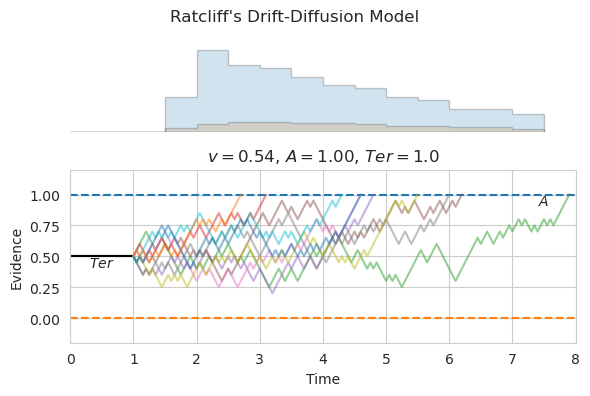

In [4]:
d = DDM(z=0., v = 0.54, ter=1.0, a= 1.0)
traces = d.run(10000)

times_a = [x[-1][0] for x in traces if x[-1][1] > d.a]
times_0 = [x[-1][0] for x in traces if x[-1][1] < 0]

fig, (axs1, axs2) = plt.subplots(2, 1, figsize=(6,4), gridspec_kw={'height_ratios': [1, 2]})

max_time = 8

axs1.set_xlim(0, max_time)
axs2.set_xlim(0, max_time)

axs1.get_xaxis().set_visible(False)
axs1.get_yaxis().set_visible(False)
axs1.axis('off')

axs2.set_ylim(-0.2, 1.2)
axs2.set_ylabel("Evidence")
axs2.set_xlabel("Time")

# The traces

axs2.plot([0, d.ter], [d.start, d.start], "k")
axs2.plot([0, max_time], [d.a, d.a], '--')
axs2.plot([0, max_time], [0, 0], '--')
axs2.plot([0, d.ter], [d.start, d.start], "k")

axs2.text(s=r"$Ter$", x=d.ter/2, y = d.start, ha='center', va = 'top')
axs2.text(s=r"$A$", x=max_time - 0.5, y = d.a, ha='center', va = 'top')

subset = rnd.choices([x for x in traces if x[-1][0] < max_time], k=10)

for trace in subset:
    data = np.array(trace)
    axs2.plot(data[:,0], data[:,1], alpha=0.5)

bins = [x/2 for x in range(0, 2*max_time)]
axs2.set_title(r"$v = %.2f$, $A = %.2f$, $Ter = %.1f$" % (d.v, d.a, d.ter)) 
kwargs = dict(histtype='stepfilled', alpha=0.2, density=False, bins=bins, ec="k")
axs1.hist((times_a, times_0), **kwargs)

fig.suptitle("Ratcliff's Drift-Diffusion Model")
fig.tight_layout()
plt.savefig("figures/ddm.png", dpi=200)
plt.show()

### Speed-Accuracy Trade-Off

The speed-accuracy trade-off can be modeled by adjusting the decision boundary $A$.

(6409, 3591)
(6150, 3850)


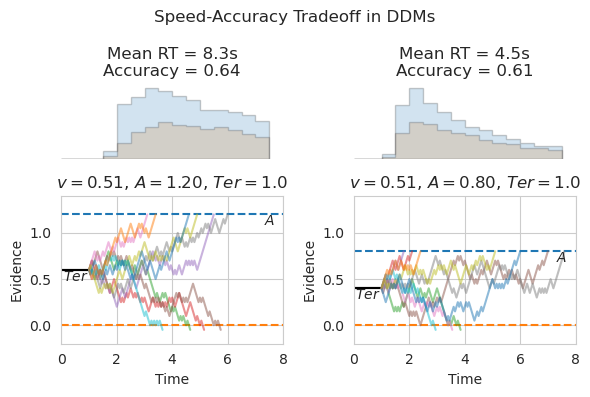

In [5]:
fig, axes = plt.subplots(2, 2, figsize=(6,4), gridspec_kw={'height_ratios': [1, 2]})

max_time = 8

for i, a in enumerate((1.2, 0.8)):
    model = DDM(z = 0., v = 0.51, ter = 1.0, a = a) 
    traces = model.run(10000)
    times_a = [x[-1][0] for x in traces if x[-1][1] > model.a]
    times_0 = [x[-1][0] for x in traces if x[-1][1] < 0]
    print((len(times_a), len(times_0)))
    ax1, ax2 = axes[:,i]
    ax1.set_xlim(0, max_time)
    ax2.set_xlim(0, max_time)

    ax1.get_xaxis().set_visible(False)
    ax1.get_yaxis().set_visible(False)
    ax1.axis('off')
    
    ax2.set_ylim(-0.2, 1.4)
    ax2.set_ylabel("Evidence")
    ax2.set_xlabel("Time")

    # The traces

    ax2.plot([0, model.ter], [model.start, model.start], "k")
    ax2.plot([0, max_time], [model.a, model.a], '--')
    ax2.plot([0, max_time], [0, 0], '--')
    ax2.plot([0, model.ter], [model.start, model.start], "k")

    ax2.text(s=r"$Ter$", x = model.ter/2, y = model.start, ha = 'center', va = 'top')
    ax2.text(s=r"$A$", x = max_time - 0.5, y = model.a, ha = 'center', va = 'top')

    subset = rnd.choices([x for x in traces if x[-1][0] < max_time], k = 10)

    for trace in subset:
        data = np.array(trace)
        ax2.plot(data[:,0], data[:,1], alpha=0.5)

    # stats:
    mean_rt = np.mean(times_a)
    mean_acc = len(times_a)/10000
    bins = [x/2 for x in range(0, 2*max_time)]
    ax1.set_title("Mean RT = %.1fs\nAccuracy = %.2f" % (mean_rt, mean_acc)) 
    ax2.set_title(r"$v = %.2f$, $A = %.2f$, $Ter = %.1f$" % (model.v, model.a, model.ter)) 
    kwargs = dict(histtype='stepfilled', alpha=0.2, density=False, bins=bins, ec="k")
    ax1.hist((times_a, times_0), **kwargs)
    
fig.suptitle("Speed-Accuracy Tradeoff in DDMs")
fig.tight_layout()
plt.savefig("figures/speed_accuracy_tradeoff.png", dpi=200)
plt.show()


### Response Bias $z$

Sometimes one option is intrinsically favored. This can be, for example, for innate response preferences (e.g., hand dominance), for prior knowledge (e.g., cued response direction), or for reward incentives (higher payoff to get it right). All of these circumstances can be modeled by adding one parameter that shifts the starting position of the trace.

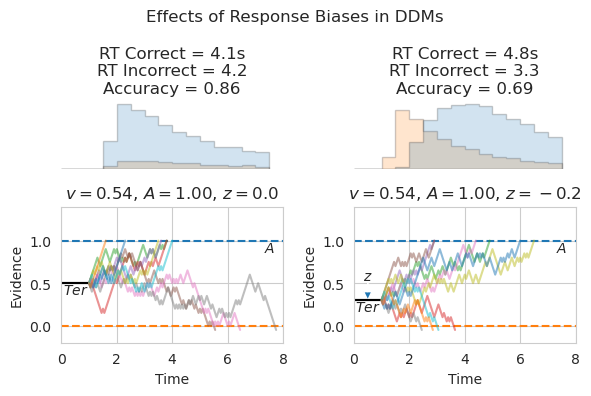

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(6,4), gridspec_kw={'height_ratios': [1, 2]})

max_time = 8

for i, z in enumerate((0, -0.2)):
    model = DDM(z = z, v = 0.54, ter = 1.0, a = 1.0) 
    traces = model.run(10000)
    times_a = [x[-1][0] for x in traces if x[-1][1] > model.a]
    times_0 = [x[-1][0] for x in traces if x[-1][1] < 0]
    #print((len(times_a), len(times_0)))
    ax1, ax2 = axes[:,i]
    ax1.set_xlim(0, max_time)
    ax2.set_xlim(0, max_time)

    ax1.get_xaxis().set_visible(False)
    ax1.get_yaxis().set_visible(False)
    ax1.axis('off')
    
    ax2.set_ylim(-0.2, 1.4)
    ax2.set_ylabel("Evidence")
    ax2.set_xlabel("Time")

    # The traces

    ax2.plot([0, model.ter], [model.start, model.start], "k")
    ax2.plot([0, max_time], [model.a, model.a], '--')
    ax2.plot([0, max_time], [0, 0], '--')
    ax2.plot([0, model.ter], [model.start, model.start], "k")

    ax2.text(s=r"$Ter$", x = model.ter/2, y = model.start, ha = 'center', va = 'top')
    ax2.text(s=r"$A$", x = max_time - 0.5, y = model.a, ha = 'center', va = 'top')
    
    if model.z != 0:
        ax2.arrow(model.ter/2, model.a/2, 0, model.z, head_length = abs(model.z)/2, head_width=0.3, length_includes_head=True)
        ax2.text(s=r"$z$", x = model.ter/2, y = model.a/2, ha = 'center', va = 'bottom')

    subset = rnd.choices([x for x in traces if x[-1][0] < max_time], k = 10)

    for trace in subset:
        data = np.array(trace)
        ax2.plot(data[:,0], data[:,1], alpha=0.5)

    # stats:
    rt_correct = np.mean([x for x in times_a if x < 8])
    rt_incorrect = np.mean([x for x in times_0 if x < 8])
    mean_acc = len(times_a)/10000
    bins = [x/2 for x in range(0, 2*max_time)]
    ax1.set_title("RT Correct = %.1fs\nRT Incorrect = %.1f\nAccuracy = %.2f" % (rt_correct, rt_incorrect, mean_acc)) 
    ax2.set_title(r"$v = %.2f$, $A = %.2f$, $z = %.1f$" % (model.v, model.a, model.z)) 
    kwargs = dict(histtype='stepfilled', alpha=0.2, density=False, bins=bins, ec="k")
    ax1.hist((times_a, times_0), **kwargs)
    
fig.suptitle("Effects of Response Biases in DDMs")
fig.tight_layout()
plt.savefig("figures/response_biases.png", dpi=200)
plt.show()


### Modeling errors

We have seen above that Ratcliff's model is commonly applied by coding the two options as the correct and incorrect response to a given stimulus, independently of the response. In this case, the drift parameter can be easily understood as a measure of decision difficulty: the easier it is to make a decision, the quicker the response times and the more likely the correct response is to be selected.

One noteworthy limitation of this approach, however, is that errors, in human experiments (and likely in primate experiments as well) exhibit different distributions of response times. The nature of this difference depends a bit on the task. When the experiment stresses quick response times.

These apparently complicated pattern can be captured by adding another source of inter-trial variability to the model---specifically, by making the drift rate vary randomly across trials. In this case, the drift rate is not constant across trials, but is drawn from a normal distribution with mean $\mu_v$ and standard deviation $\sigma_v$: $v \sim \mathcal{N}(\mu_v, \sigma_v)$

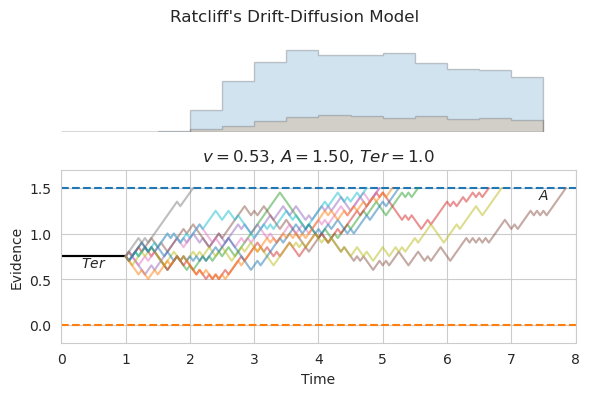

In [7]:
#fig, (axs1, axs2, axs3) = plt.subplots(3, 1, figsize=(5,5), gridspec_kw={'height_ratios': [1, 2, 1]})

d = DDM(z=0., v = 0.53, ter=1.0, a= 1.5, sdv=0.02)
traces = d.run(10000)

times_a = [x[-1][0] for x in traces if x[-1][1] > d.a]
times_0 = [x[-1][0] for x in traces if x[-1][1] < 0]

fig, (axs1, axs2) = plt.subplots(2, 1, figsize=(6,4), gridspec_kw={'height_ratios': [1, 2]})

max_time = 8

axs1.set_xlim(0, max_time)
axs2.set_xlim(0, max_time)
#axs3.set_xlim(0, max_time)

for ax in (axs1,):#, axs3):
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.axis('off')
    #ax.set_ylim(0, 2000)`
    #axs3.set_ylim(0, 10)

axs2.set_ylim(-0.2, d.a + 0.2)
axs2.set_ylabel("Evidence")
axs2.set_xlabel("Time")

#axs3.invert_yaxis()

# The traces

axs2.plot([0, d.ter], [d.start, d.start], "k")
axs2.plot([0, max_time], [d.a, d.a], '--')
axs2.plot([0, max_time], [0, 0], '--')
axs2.plot([0, d.ter], [d.start, d.start], "k")

axs2.text(s=r"$Ter$", x=d.ter/2, y = d.start, ha='center', va = 'top')
axs2.text(s=r"$A$", x=max_time - 0.5, y = d.a, ha='center', va = 'top')
#axs2.text(s=r"$0$", x=max_time - 0.5, y = 0, ha='center', va = 'bottom')

subset = rnd.choices([x for x in traces if x[-1][0] < max_time], k=10)

for trace in subset:
    data = np.array(trace)
    axs2.plot(data[:,0], data[:,1], alpha=0.5)

bins = [x/2 for x in range(0, 2*max_time)]
axs2.set_title(r"$v = %.2f$, $A = %.2f$, $Ter = %.1f$" % (d.v, d.a, d.ter)) 
kwargs = dict(histtype='stepfilled', alpha=0.2, density=False, bins=bins, ec="k")
axs1.hist((times_a, times_0), **kwargs)
fig.suptitle("Ratcliff's Drift-Diffusion Model")
fig.tight_layout()
plt.show()


## Race Models

Race models have only one boundary.

### The Linear Ballistic Accumulator model 

The LBA is a random-ray model. The drift rate is the angle at which the ray is movinbg towards the boundary. Inter-trial variability comes from teh angle being drawn from a normal distribution.

In [8]:
class LBA:
    """Brown and Heathcote's Linear Ballistic Accumulator""" 
    def __init__(self, v, a, ter, vsd=0.1):
        """Initializes the main parameters"""
        self.v = v
        self.a = a
        self.ter = ter
        self.vsd = vsd
        
    def trial(self):
        """Simulates a single trial as a random ray"""
        #angle = min(math.pi/4, max(1.0e-6, rnd.gauss(self.v, self.vsd)))
        #ray_length = self.a / np.sin(angle)
        #t = self.a / np.tan(angle)
        slope = max(0.000000001, rnd.gauss(self.v, self.vsd))
        intersect = self.a / slope
        return (self.ter + intersect, self.a)
        #return (t + self.ter, self.a)
    
    def run(self, n = 1000):
        """Simulates N trials"""
        traces = []
        for i in range(n):
            traces.append(self.trial())
            
        return traces

Here is an illustration of the LBA in action

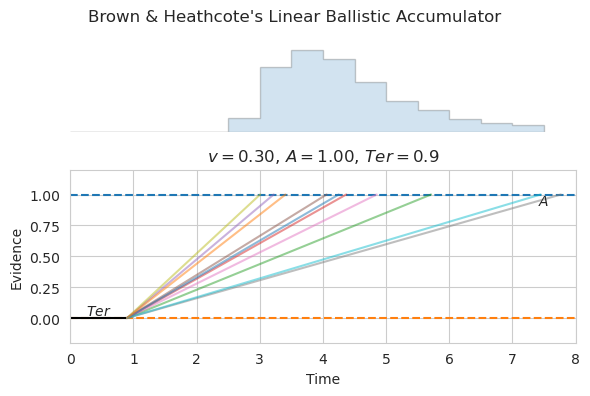

In [9]:
lba = LBA(v = 0.3, a = 1, ter=0.9)

traces = lba.run(10000)

fig, (axs1, axs2) = plt.subplots(2, 1, figsize=(6,4), gridspec_kw={'height_ratios': [1, 2]})

max_time = 8

axs1.set_xlim(0, max_time)
axs2.set_xlim(0, max_time)

for ax in (axs1,):#, axs3):
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.axis('off')

axs2.set_ylim(-0.2, lba.a + 0.2)
axs2.set_ylabel("Evidence")
axs2.set_xlabel("Time")

# The traces

axs2.plot([0, max_time], [lba.a, lba.a], '--')
axs2.plot([0, max_time], [0, 0], '--')
axs2.plot([0, lba.ter], [0, 0], "k")

axs2.text(s=r"$Ter$", x=lba.ter/2, y = 0, ha='center', va = 'bottom')
axs2.text(s=r"$A$", x=max_time - 0.5, y = lba.a, ha='center', va = 'top')

subset = rnd.sample([x for x in traces if x[0] < max_time], k = 10)

for trace in subset:
    axs2.plot([lba.ter, trace[0]], [0, trace[1]], alpha=0.5)

bins = [x/2 for x in range(0, 2*max_time)]
axs2.set_title(r"$v = %.2f$, $A = %.2f$, $Ter = %.1f$" % (lba.v, lba.a, lba.ter)) 
kwargs = dict(histtype='stepfilled', alpha=0.2, density=False, bins=bins, ec="k")
axs1.hist([t[0] for t in traces], **kwargs)
#axs3.hist((times_a, times_0), **kwargs)
fig.suptitle("Brown & Heathcote's Linear Ballistic Accumulator")
fig.tight_layout()
plt.savefig("figures/lba.png", dpi=200)
plt.show()


# Fitting an Accumulator Model

Now we are going to demonstrate how we can fit a DDM model to real data.   


In [10]:
data = pd.read_csv('simon_data.csv')
data

,Participant,Trial,Position,TrialType,Correct,RT
0,42012,13,Right,C,1,729
1,42012,14,Right,C,1,435
2,42012,15,Right,C,1,377
3,42012,16,Left,C,1,352
4,42012,17,Left,C,1,329
5,42012,18,Left,I,1,611
6,42012,19,Left,C,1,834
7,42012,20,Right,C,1,520
8,42012,21,Right,C,1,459
9,42012,22,Right,I,1,575


We are going to plot the histogram of response times together with the estimated probability distrubution

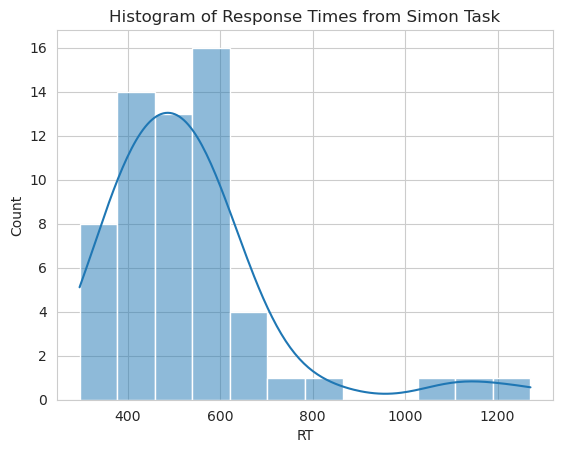

In [11]:
ax = sns.histplot(data, x="RT", kde=True)
ax.set_title("Histogram of Response Times from Simon Task")
plt.show()


## Loss Function

Since we are going to reproduce the distribution of RTs, we are going to use the Kullback-Leiber divergence $D_{KL}$:

$$ D_{KL}(P||Q) = \int_x P(x) \times \log \frac{P(x)}{Q(x)}$$

The KL divergence measures hhow much the distribution $P$ difference from $Q$; formally, it can be interpreted as the increase _surprise_ that is observed if one replaces $P$ with $Q$. In our case, $Q$ is the model's prediction and $P$ is the empirical data:

$$ D_{KL}(P||Q) = \int_x P_{data}(x) \times \log \frac{P_{data}(x)}{P_{model}(x)}$$

In practice, we always deal with finite distributions and samples:

$$ D_{KL}(P||Q) = \sum_{i=1}^n   P_{data}(i) \times \log \frac{P_{data}(i)}{P_{model}(i)} $$

## Computing Probability Densities

Note that the KL function is computed over a series of _probabilities_, which must be between 0 and 1 (and must be strictly > 0, because of the logarithm and the fraction). What we do have is instead a histogram of values. To turn histograms into probabilities, we can use a _kernel density estimator_ (KDE):

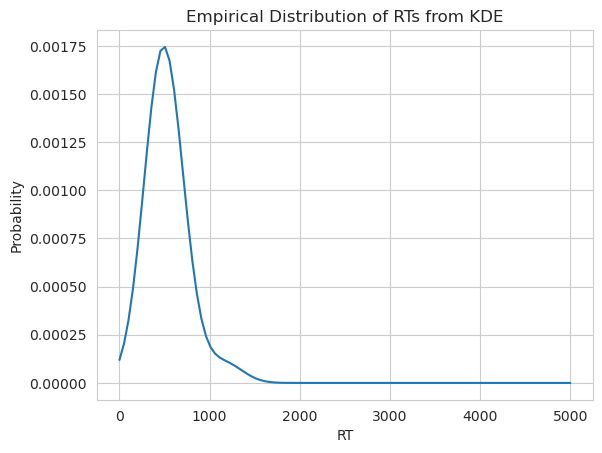

In [12]:
empirical_kde = stat.gaussian_kde(data.RT, bw_method=1)
x = np.linspace(0, 5000, 100)
empirical_dist = [empirical_kde(i) for i in x]
plt.plot(x, empirical_dist)
plt.title("Empirical Distribution of RTs from KDE")
plt.xlabel("RT")
plt.ylabel("Probability")
plt.show()

Now we can define our loss function. It takes a vector of parameters $\theta = {v, A, T_{ER}, SD_v}$ and does the following:

* It creates a new LBA model with the parameters in $\theta$;
* Runs the LBA model 10,000 times and collectes the response times.
* Computes the distribution fo RTs using Kernel Density estimation/
* Computes the KL divergence using the probability values estimated from the KDE of the empirical data and the KDE of the model's responses
* Returns the value of the KL divergence.

In [45]:
def loss(X):
    v, ter, a, vsd = X 
    lba = LBA(v = v, ter=ter, a= a, vsd = vsd)
    traces = lba.run(10000)
    predicted = [x[0]*1000 for x in traces]
    model_kde = stat.gaussian_kde(np.array(predicted), bw_method=100)
    model_dist = [model_kde(x) for x in np.linspace(0, 5000, 100)]
    
    return stat.entropy(empirical_dist, model_dist)

aspace = np.linspace(0.5, 5.5, 11)
vspace = np.linspace(0, 5, 11)
matrix = np.zeros((len(terspace), len(vspace)))

for i, a in enumerate(aspace):
    for j, v in enumerate(vspace):
        matrix[i,j] = loss(np.array([v, 0.35, a, 0.06]))


And now we can visualize the results

/tmp/ipykernel_10938/3083046263.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + [str(round(x,2)) for x in terspace])
/tmp/ipykernel_10938/3083046263.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + [str(round(x, 2)) for x in vspace])


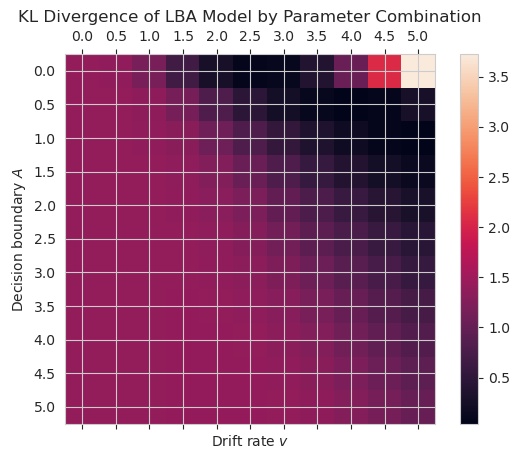

In [49]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(matrix, interpolation='nearest')
fig.colorbar(cax)

ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.set_xticklabels([''] + [str(round(x,2)) for x in terspace])
ax.set_yticklabels([''] + [str(round(x, 2)) for x in vspace])
ax.set_ylabel(r"Decision boundary $A$ ")
ax.set_xlabel(r"Drift rate $v$ ")
ax.set_title("KL Divergence of LBA Model by Parameter Combination")
plt.show()

With the loss function in place, we now can apply, again, standard optimization techniques. This time we are going to use _Powell_'s method (instead o the Nelder-Mead algorithm) because it allows for the specification fo boundaries for the space of each parameter. These boundaries are needed because some values are constrained. For example, all parameter values must be positive.

In [33]:
res = scipy.optimize.minimize(loss, x0=[0.1, 3, 3,1],
                              method="Powell", bounds=[[0.0001, 5], 
                                                       [0, 1], 
                                                       [0.0001, 5],
                                                       [0.0001,1]],
                             tol=0.1)
print(res)

/tmp/ipykernel_10938/1589968849.py:1: OptimizeWarning: Initial guess is not within the specified bounds
  res = scipy.optimize.minimize(loss, x0=[0.1, 3, 3,1],


 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 0.038526808667264836
       x: [ 4.785e+00  3.520e-01  1.379e+00  5.582e-02]
     nit: 5
   direc: [[ 1.000e+00  0.000e+00  0.000e+00  0.000e+00]
           [ 0.000e+00  1.000e+00  0.000e+00  0.000e+00]
           [ 0.000e+00  0.000e+00  0.000e+00  1.000e+00]
           [-3.602e-03  1.342e-01 -3.552e-01  0.000e+00]]
    nfev: 159


And now, we can visualize how well our midel's distribution of RTs matches the results from the Simon experiment.

[4.78535591 0.35201762 1.37927034 0.05582252]
[0.14283489]


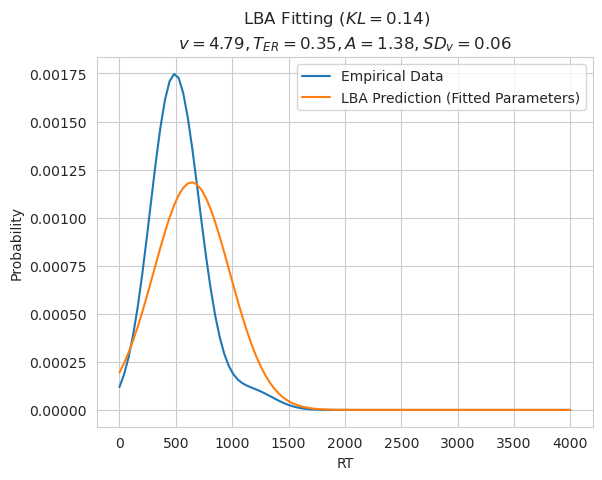

In [48]:
# Generate high-density RT space for better viz
rtx = np.linspace(0, 4000, 100)

# Re-generate empirical RT Distribution

empirical_dist = [empirical_kde(i) for i in rtx]


# RT Dist with default values

lba = LBA(v=3, ter=2, a=1, vsd=0.1)
traces = lba.run(10000)
predicted = [x[0]*1000 for x in traces]
labdist = stat.gaussian_kde(predicted, bw_method=100)
default_dist = [labdist(i) for i in rtx]

# RT Dist with Optimized values

vstar, terstar, astar, vsdstar = res.x
print(res.x)

lbastar = LBA(v=vstar, ter=terstar, a=astar, vsd=vsdstar)
traces = lbastar.run(10000)
predicted = [x[0] * 1000 for x in traces]
labdist = stat.gaussian_kde(predicted, bw_method=100)
optimized_dist = [labdist(i) for i in rtx]

# Compute KL

kl = stat.entropy(empirical_dist, optimized_dist)
print(kl)

plt.plot(rtx, empirical_dist, label="Empirical Data")
#plt.plot(rtx, default_dist, label="LBA Prediction (Default Parameters)")
plt.plot(rtx, optimized_dist, label="LBA Prediction (Fitted Parameters)")
#ax.set_title("simulated LBA data")
plt.legend()
plt.suptitle("LBA Fitting ($KL = %.2f$)" % (kl))
plt.title("$v = %.2f, T_{ER} = %.2f, A= %.2f, SD_v = %.2f$" % (vstar, terstar, astar, vsdstar))
plt.xlabel("RT")
plt.ylabel("Probability")
plt.show()